In [2]:
import sys
import glob
from pathlib import Path
sys.path.append('./extract_patches.py')
import extract_patches as ep
from matplotlib import pyplot as plt

In [3]:
def show_info(x,show_values = False):
    length = 'no length'
    keys = 'no a dict'
    values = 'no a dict'
    if hasattr(x,'__len__'):
        length = len(x)
    if isinstance(x,dict):
        keys = x.keys()
        values = x.values()
    if show_values:
        print(f'type:{type(x)} \nlen:{len(x)}\nkeys:{keys}\nvalues:{values}\noriginal info:{x}')
    else:
        print(f'type:{type(x)} \nlen:{len(x)}\nkeys:{keys}\noriginal info:{x}')

In [4]:
root_path = {
    'server':'',
    'desktop':'I:\\TCGA_bladder\\TCGA_bladder\\',
    'laptop':''
}
file_id = '1a985a2b-c025-4336-a0f5-8b13fbbbba91' + '\\'

In [5]:
file_path = root_path['desktop'] + file_id
svs_path = glob.glob(file_path + '*.svs')
xml_path = glob.glob(file_path + '*.xml')

g:\gitcode\patho_AI\processing\extract_patches.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.array(mask_coords[cls])


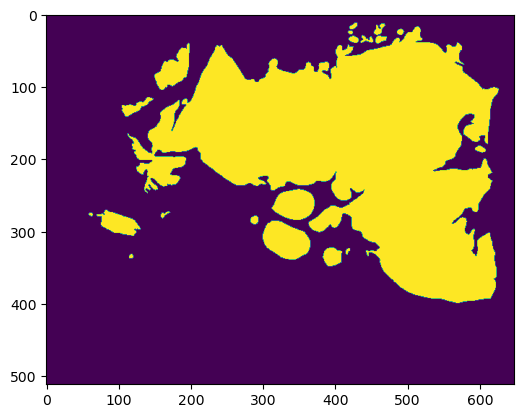

In [6]:
slide = ep.get_slide(svs_path[0]) #svs_path是一个list
mask_coords,classes = ep.AnnotationParser(xml_path[0])
anno = ep.Annotation(slide,xml_path[0])
masked_tumor = ep.show_thumb_mask(anno['tumor'])

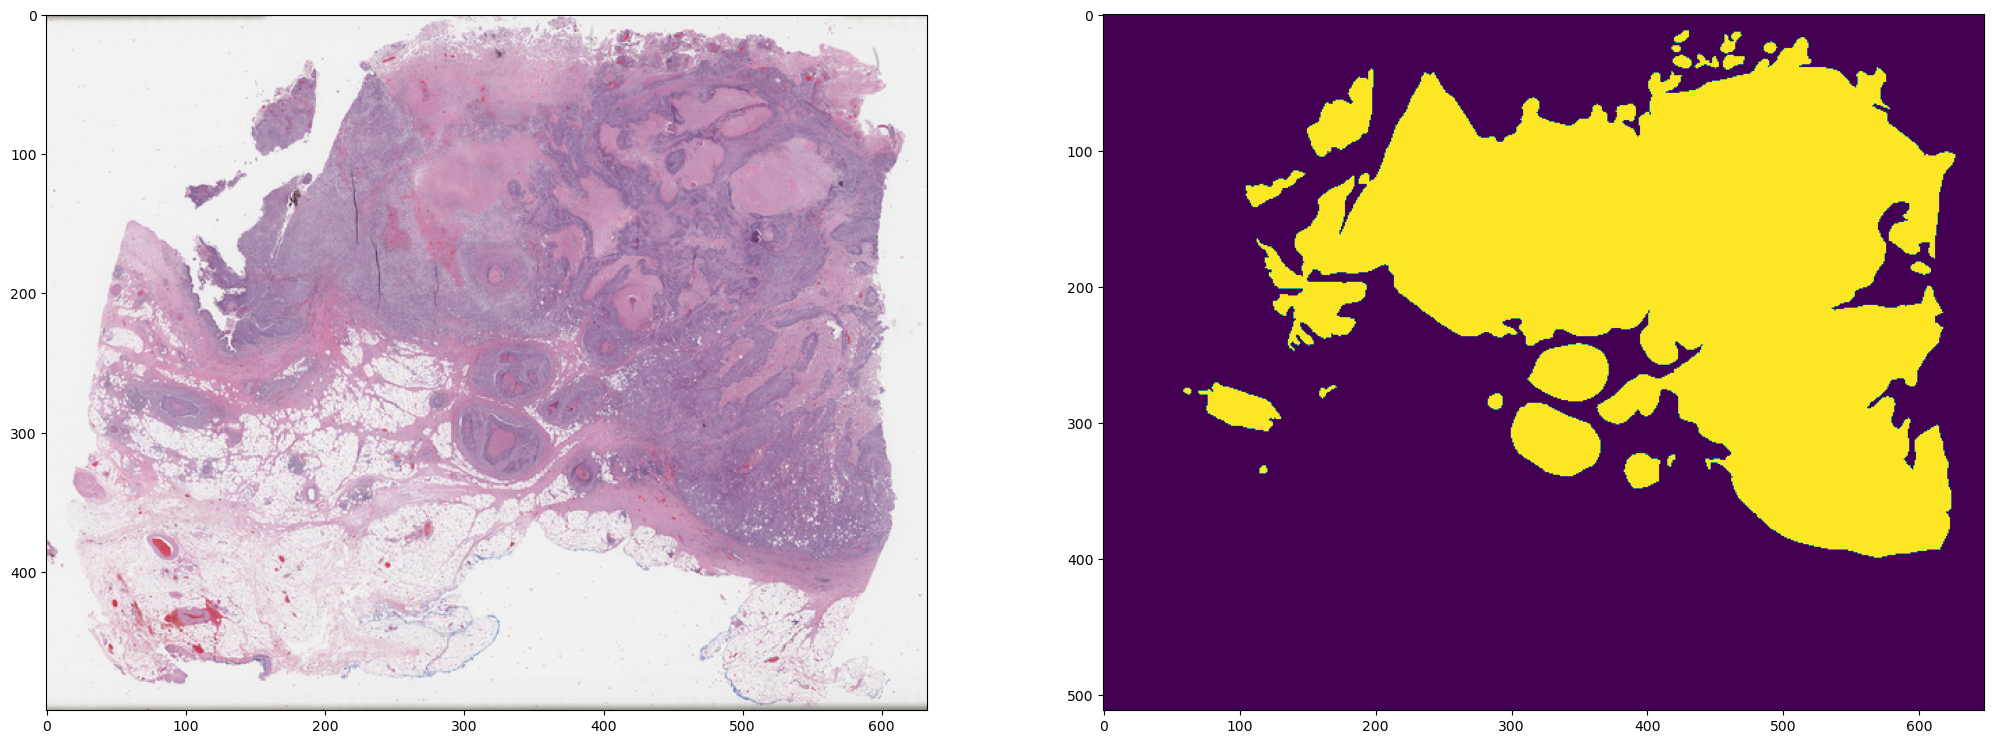

In [8]:
figure = plt.figure(figsize=(25,10))
original = plt.subplot(121)
original.imshow(slide.get_thumbnail((1000,500)))
masked = plt.subplot(122)
masked.imshow(masked_tumor)